# IDG Test

Results from IDG test benchmarks.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in bytes.

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Defined benchmarks

Currently, benchmark has two major variants namely, `SKA1_low` and `SKA1_mid`. Both use the antenna configuration for SKA1 LOW and MID, respectively. Besides, there are other variables that can be configured at the runtime of the test to control size of the benchmark.

## Latest run performance metrics

All the performance metrics are tabulated from the latest benchmark run for different systems/parititons and programming environments

### SKA1 low results
These results correspond to SKA1 low configuration results.

The table shows results for different systems/partition/environments.

In [4]:
test = 'IdgTest*'
df = modules.utils.tabulate_last_perf(test=test,
                                      root=PERFLOG_DIR,
                                      extras=['layout'])
if df is None:
    print('%s: no performance logs found' % test)
else:
    df = df.transpose() # so now cols are all, single
    display(df)

perf_var                                                   degridding Mvis/s  \
case                                             layout                        
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low               1.89   
gitlab-ci:k8-runner:idg-test                     SKA1_low               0.48   

perf_var                                                   degridding s  \
case                                             layout                   
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low        1070.5   
gitlab-ci:k8-runner:idg-test                     SKA1_low        4245.1   

perf_var                                                     fft s  \
case                                             layout              
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low   0.3948   
gitlab-ci:k8-runner:idg-test                     SKA1_low  33.1080   

perf_var                                                   get_image s  \
case                                             layout                  
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low      6.51370   
gitlab-ci:k8-runner:idg-test                     SKA1_low      0.27586   

perf_var                                                   gridding Mvis/s  \
case                                             layout                      
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low             3.18   
gitlab-ci:k8-runner:idg-test                     SKA1_low             0.68   

perf_var                                                   gridding s  \
case                                             layout                 
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low      637.82   
gitlab-ci:k8-runner:idg-test                     SKA1_low     2989.50   

perf_var                                                   imaging Mvis/s  \
case                                             layout                     
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low            1.01   
gitlab-ci:k8-runner:idg-test                     SKA1_low            0.27   

perf_var                                                   imaging s  
case                                             layout               
nancy-g5k:grouille-gcc9-ompi4-eth-umod-nvgpu:idg SKA1_low     1999.8  
gitlab-ci:k8-runner:idg-test                     SKA1_low     7640.7

## Performance History

The plot shows the gridding throughput for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

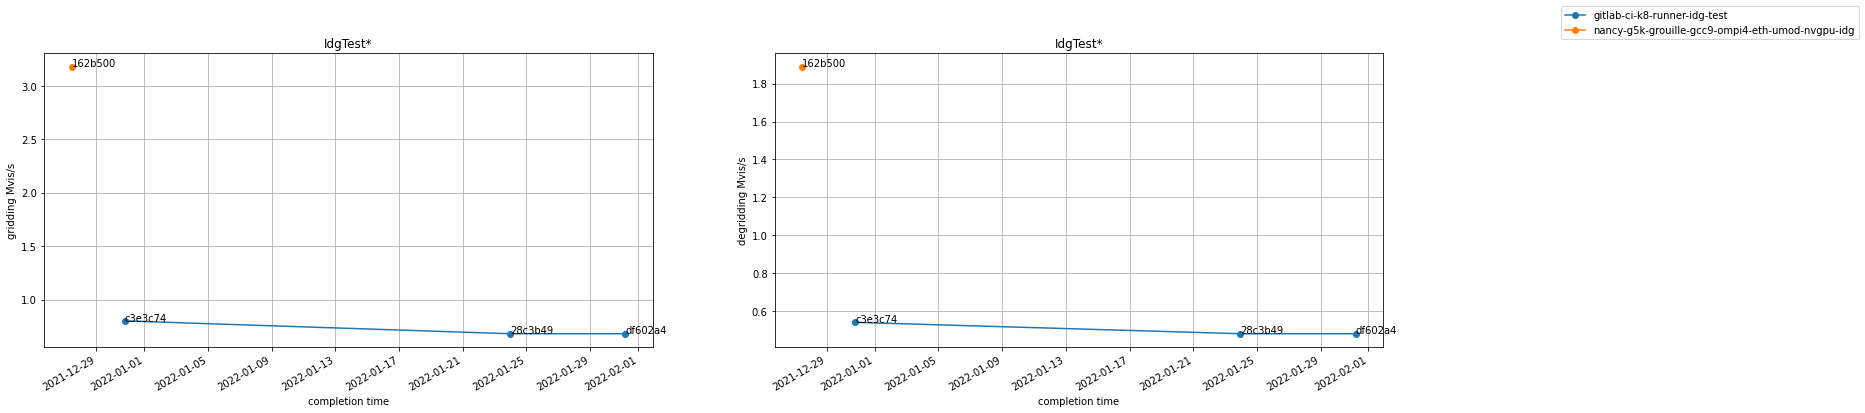

In [5]:
test='IdgTest*'
perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, test=test)
if perf_records is None:
    print('%s: no performance logs found' % test)
else:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
    for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
        # filter to only Gflops records (might have others)
        for iplot, perf_var in enumerate(['gridding Mvis/s', 'degridding Mvis/s']):
            df = data.loc[data['perf_var'] == perf_var]
            df.plot(ax=ax[iplot], x='completion_time', y='perf_value', style=['o-'], label='-'.join(spe), legend=None)

            # annotate points with git_ref:
            for x, y, ref in zip(df['completion_time'], df['perf_value'], df['git']):
                if not pd.isnull(ref):
                    ax[iplot].annotate(ref[:7], (x, y))
            ax[iplot].set_title(test)
            ax[iplot].set_xlabel('completion time')
            ax[iplot].set_ylabel(perf_var)
            ax[iplot].grid()
    handles, labels = ax[iplot].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')